# Second homework of Statistical Learning #

### By Grégoire DHIMOÏLA - May 2023 ###

In [1]:
from fancy_einsum import einsum
import torch
from tqdm import tqdm

from PIL import Image as img
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\gdhim\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def normalize(data):
    return (data - data.mean()) / data.std()

In [3]:
test_data = torch.zeros((750, 28, 28)).to(device)
test_labels = torch.ones(750, dtype=torch.long).to(device)
test_labels[250:] = -1

train_data = torch.zeros((900, 28, 28)).to(device)
train_labels = torch.zeros(900).to(device)

print("loading the data...")

for i in tqdm(range(300)):
    train_data[i] = torch.tensor(np.array(img.open('data2/train/A/A_train_' + str(i+1) + '.png'))).to(device)
    train_labels[i] = 1
    
    train_data[i+300] = torch.tensor(np.array(img.open('data2/train/B/B_train_' + str(i+1) + '.png'))).to(device)
    train_labels[i+300] = -1

    train_data[i+600] = torch.tensor(np.array(img.open('data2/train/C/C_train_' + str(i+1) + '.png'))).to(device)
    train_labels[i+600] = -1

train_data = normalize(train_data)

print("Done.")

print('Loading test...')
for i in tqdm(range(250)):
    test_data[i] = torch.tensor(np.array(img.open('data2/test/A/A_test_' + str(i+1) + '.png'))).to(device)
    test_data[i + 250] = torch.tensor(np.array(img.open('data2/test/B/B_test_' + str(i+1) + '.png'))).to(device)
    test_data[i + 500] = torch.tensor(np.array(img.open('data2/test/C/C_test_' + str(i+1) + '.png'))).to(device)
print('Done.')

test_data = normalize(test_data)

loading the data...


100%|██████████| 300/300 [00:00<00:00, 855.19it/s]


Done.
Loading test...


100%|██████████| 250/250 [00:00<00:00, 1176.85it/s]

Done.


## Regularization of Logistic Regression ##

The following section contains my implementation of the first part of the homework.

In [4]:
# define the loss function

def lin_loss(pred, label):
    return (pred - label) ** 2

def logist_loss(pred, label):
    return torch.log(1 + torch.minimum(torch.exp(-label * pred), torch.ones_like(pred) * 1e16))

# define the gradient function

def lin_grad(pred, label, x):
    return einsum('b, b i j -> i j', 2 * (pred - label), x) / x.shape[0], 2 * (pred - label).mean()


def logist_grad(pred, label, x):
    return einsum('b, b i j -> i j', -label * torch.sigmoid(-pred * label), x) / x.shape[0], (-label * torch.sigmoid(-pred * label)).mean()

# define the regularized loss function

class L1_Regularizer:
    def __init__(self, lambda_):
        self.lambda_ = lambda_

    def regularized_logist_loss(self, pred, label, model):
        return logist_loss(pred, label) + self.lambda_ * torch.norm(model.beta, p=1)

    def regularized_grad(self, pred, label, x, model):
        unregularized = logist_grad(pred, label, x)
        return unregularized[0] + self.lambda_ * torch.sign(model.beta), unregularized[1]
    
    def __call__(self, pred, label, model):
        return self.regularized_logist_loss(pred, label, model)
    
class L2_Regularizer:
    def __init__(self, lambda_):
        self.lambda_ = lambda_

    def regularized_logist_loss(self, pred, label, model):
        return logist_loss(pred, label) + self.lambda_ * torch.norm(model.beta, p=2) ** 2
    
    def regularized_grad(self, pred, label, x, model):
        unregularized = logist_grad(pred, label, x)
        return unregularized[0] + 2 * self.lambda_ * model.beta, unregularized[1]

    def __call__(self, pred, label, model):
        return self.regularized_logist_loss(pred, label, model)

In [6]:
class Model:
    def __init__(self):
        self.beta = torch.randn(28, 28).to(device)
        self.beta = self.beta / torch.norm(self.beta)

        self.bias = torch.randn(1).to(device)
        
    def correlation(self, x : torch.Tensor) -> torch.Tensor:
        #beta : (28, 28)
        #x : (batch_size, 28, 28)
        #compute the correlation between the image and the model
        
        return einsum('b i j, i j -> b', x, self.beta)
    
    def train(self, loss_function, lr, batch_size, epochs, verbose = True):
        training_loss = []
        test_loss = []
        training_accuracy = []
        test_accuracy = []

        max_accuracy = 0

        x_trainings = []
        x_tests = []

        average_beta = torch.zeros_like(self.beta).to(device)
        averages = []

        iter = tqdm(range(epochs)) if verbose else range(epochs)

        for epoch in iter:
            #shuffle the data
            #please note that when the batch is the whole dataset, shuffling is not necessary.
            perm = torch.randperm(train_data.shape[0])
            train_data_shuffle = train_data[perm]
            train_labels_shuffle = train_labels[perm]

            #train the model
            for i in range(0, train_data_shuffle.shape[0]//batch_size):
                x = train_data_shuffle[i*batch_size:(i+1)*batch_size]
                y = train_labels_shuffle[i*batch_size:(i+1)*batch_size]
                pred = self(x)
                if isinstance(loss_function, L1_Regularizer) or isinstance(loss_function, L2_Regularizer) :
                    loss = loss_function(pred, y, self)
                else :
                    loss = loss_function(pred, y)

                if loss_function == lin_loss:
                    grad = lin_grad(pred, y, x)
                elif loss_function == logist_loss:
                    grad = logist_grad(pred, y, x)
                elif isinstance(loss_function, L1_Regularizer) or isinstance(loss_function, L2_Regularizer) :
                    grad = loss_function.regularized_grad(pred, y, x, self)
                
                self.beta = self.beta - lr * grad[0]
                self.bias = self.bias - lr * grad[1]

                training_loss.append(torch.mean(loss).item())

                #compute the accuracy for the pred :
                #the prediction is just the sign of the correlation ("pred")

                pred = torch.sign(pred)
                training_accuracy.append(torch.mean((pred == y).float()).item())

                x_trainings.append(i + epoch * train_data_shuffle.shape[0] // batch_size)
            
            #test the model
            pred = self(test_data)
            if isinstance(loss_function, L1_Regularizer) or isinstance(loss_function, L2_Regularizer) :
                loss = loss_function(pred, test_labels, self)
            else :
                loss = loss_function(pred, test_labels)

            test_loss.append(torch.mean(loss).item())

            pred = torch.sign(pred)
            test_accuracy.append(torch.mean((pred == test_labels).float()).item())
            max_accuracy = max(max_accuracy, test_accuracy[-1])

            x_tests.append(epoch * train_data_shuffle.shape[0] // batch_size)

            if verbose:
                average_beta = epochs / (epochs + 1) * average_beta + 1 / (epochs + 1) * self.beta

                if epoch in [0, 9, 99, 999, 9999]:
                    averages.append(average_beta)
            
            if max_accuracy > 1.05*test_accuracy[-1]:
                break
        
        return training_loss, training_accuracy, test_loss, test_accuracy, x_trainings, x_tests, averages

    def __call__(self, x):
        return (self.correlation(x) + self.bias).sign()

In [7]:
class DM2:
    def Q1_B(self, regularizer = "L1", lr = 1e-2, batch_size = 900, epochs = 100):
        lambda_list = torch.logspace(-5, 5, 100)

        print("Computing the accuracy for each lambda...")

        training_accuracies = []
        test_accuracies = []
        model_norms = []

        for lambda_ in tqdm(lambda_list):
            model = Model()
            
            if regularizer == "L1":
                loss_function = L1_Regularizer(lambda_)
            elif regularizer == "L2":
                loss_function = L2_Regularizer(lambda_)

            _, training_accuracy, _, test_accuracy, _, _, _ = model.train(loss_function, lr, batch_size, epochs, verbose = False)
            
            model_norms.append(torch.norm(model.beta, p = 1 if regularizer == "L1" else 2).item())
            training_accuracies.append(training_accuracy[-1])
            test_accuracies.append(test_accuracy[-1])

        print("Done.")

        self.model_norms = model_norms
        self.training_accuracies = training_accuracies
        self.test_accuracies = test_accuracies
        self.lambda_list = lambda_list

        #plot the accuracy and the norm of the model according to lambda
        fig, ax = plt.subplots()

        ax.plot(self.lambda_list, self.training_accuracies, label = "training accuracy")
        ax.plot(self.lambda_list, self.test_accuracies, label = "test accuracy")

        ax.set_xlabel("lambda")
        ax.set_ylabel("accuracy")
        
        plt.legend()
        plt.loglog()

        ax2 = ax.twinx()
        ax2.plot(self.lambda_list, self.model_norms, label = "model norm", color = "red")
        ax2.set_ylabel("model norm")
        
        plt.title("Accuracy & norm VS lambda")
        plt.legend()

        plt.loglog()
        plt.show()
    
    def Q1_C(self, data, labels, regularizer = "L1", rang = (-2, 0)):
        #implement the K-fold cross validation here. We will use K = 5.
        K = 5

        perm = torch.randperm(900)
        train_data_shuffled = data[perm]
        train_labels_shuffled = labels[perm]

        data_folds = torch.split(train_data_shuffled, 180)
        labels_folds = torch.split(train_labels_shuffled, 180)

        lamda_per_decade = 100
        lambda_list = torch.logspace(rang[0], rang[1], lamda_per_decade * (rang[1] - rang[0]))
        errors = torch.zeros(K, lamda_per_decade * (rang[1] - rang[0]))
        model_norms = torch.zeros(K, lamda_per_decade * (rang[1] - rang[0]))

        for lambda_index, lambda_ in enumerate(tqdm(lambda_list)):
            for fold_index in range(K):
                train_data = torch.cat(data_folds[:fold_index] + data_folds[fold_index+1:])
                train_labels = torch.cat(labels_folds[:fold_index] + labels_folds[fold_index+1:])

                test_data = data_folds[fold_index]
                test_labels = labels_folds[fold_index]

                model = Model()

                if regularizer == "L1":
                    loss_function = L1_Regularizer(lambda_)
                elif regularizer == "L2":
                    loss_function = L2_Regularizer(lambda_)

                _, _, _, test_acc, _, _, _ = model.train(loss_function, 1e-2, 720, 100, verbose = False)
                errors[fold_index, lambda_index] = 1 - test_acc[-1]
                model_norms[fold_index, lambda_index] = torch.norm(model.beta)
            
        errors = torch.mean(errors, dim = 0)
        model_norms = torch.mean(model_norms, dim = 0)
        best_lambda = lambda_list[torch.argmin(errors)]

        print("Best lambda:", best_lambda)
        #plot the error and norm for each lambda
        fig, ax = plt.subplots()

        ax.plot(lambda_list, errors, label = "mean errors")

        ax.set_xlabel("lambda")
        ax.set_ylabel("error")
        
        plt.legend()
        plt.loglog()

        ax2 = ax.twinx()
        ax2.plot(lambda_list, model_norms, label = "model norm", color = "red")
        ax2.set_ylabel("model norm")
        
        plt.title("error & norm VS lambda")
        plt.legend()

        plt.loglog()
        plt.show()

    def Q1_D(self, lambda_list, regularizer = "L1"):
        #plot the image beta for each lambda
        for lambda_ in lambda_list:
            model = Model()

            if regularizer == "L1":
                loss_function = L1_Regularizer(lambda_)
            elif regularizer == "L2":
                loss_function = L2_Regularizer(lambda_)

            _ = model.train(loss_function, 1e-2, 900, 100, verbose = False)

            beta = model.beta.cpu().detach().numpy()
            plt.imshow(beta)#, cmap = "gray")
            plt.title("lambda = " + str(lambda_))
            plt.show()

dm2 = DM2()

Computing the accuracy for each lambda...


100%|██████████| 100/100 [00:06<00:00, 14.93it/s]


Done.


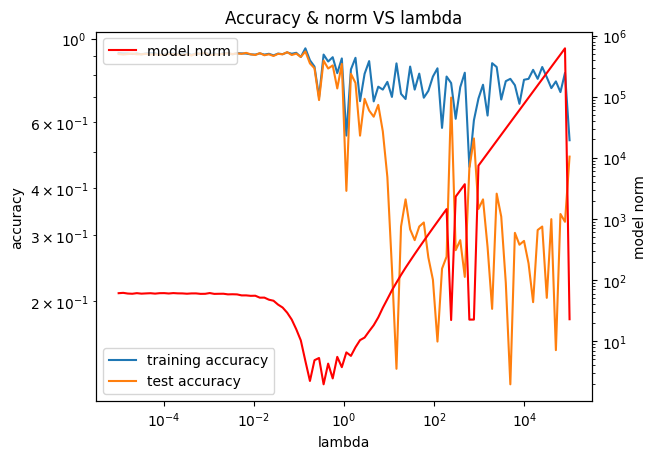

100%|██████████| 200/200 [01:43<00:00,  1.93it/s]


Best lambda: tensor(0.1275)


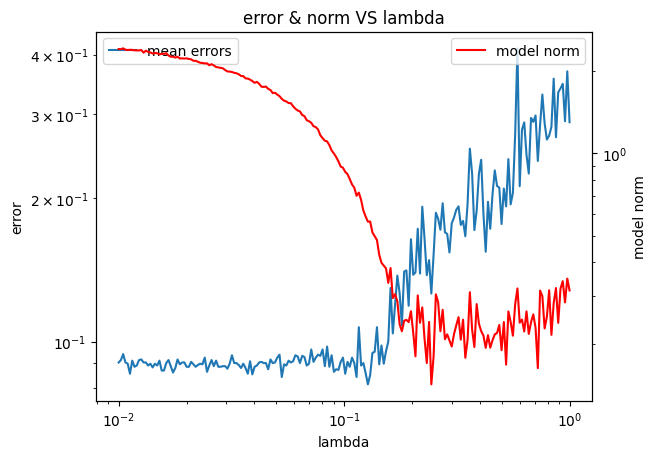

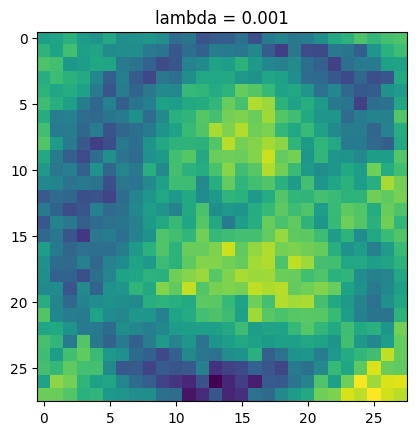

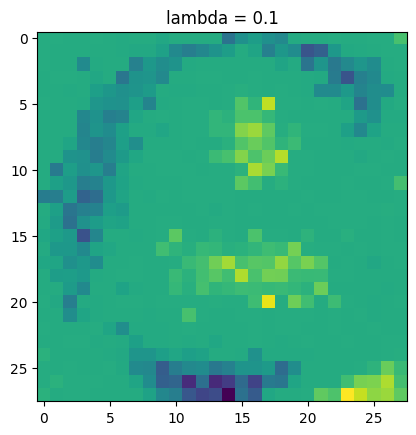

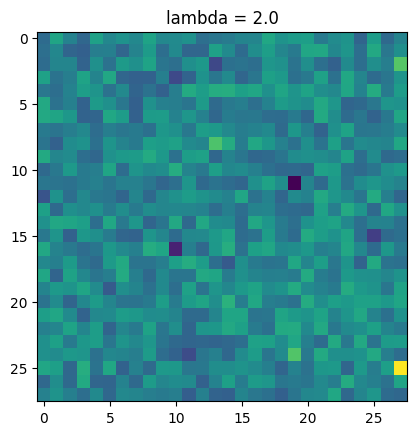

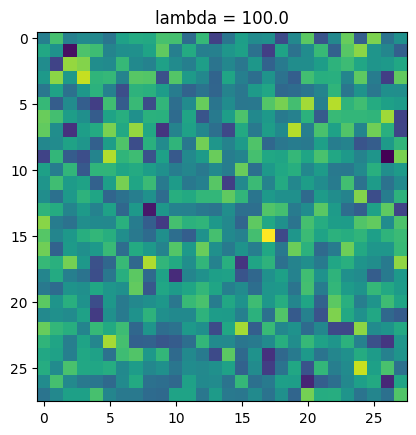

In [8]:
dm2.Q1_B(regularizer="L1")
# /!\ Please note that if question C takes too much time for your computer, you can reduce the k of the k-fold cross validation, and you can reduce the number of lambda per decade.
dm2.Q1_C(train_data, train_labels, regularizer="L1", rang=(-2, 0))
dm2.Q1_D([1e-3, 1e-1, 2e0, 1e2], regularizer="L1")

Computing the accuracy for each lambda...


100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


Done.


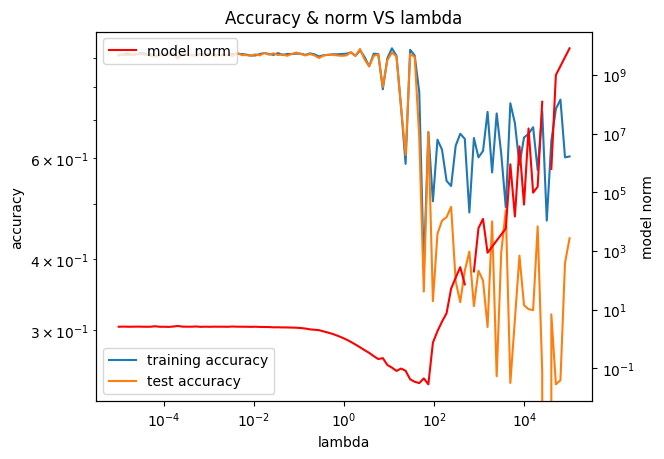

100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Best lambda: tensor(9.8850)


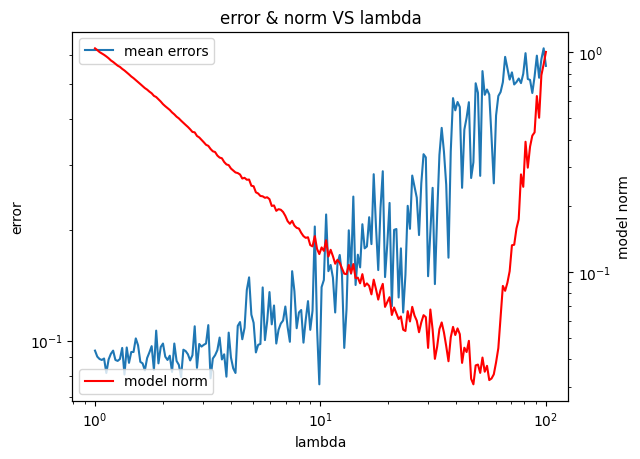

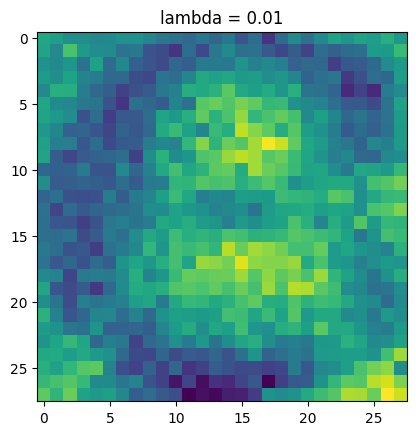

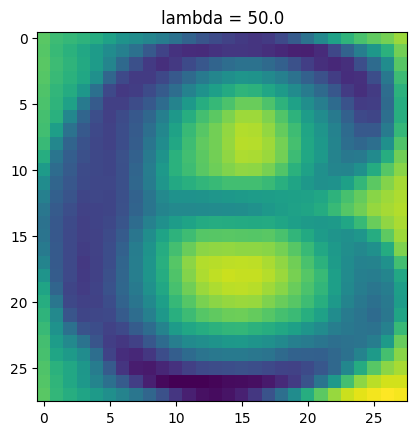

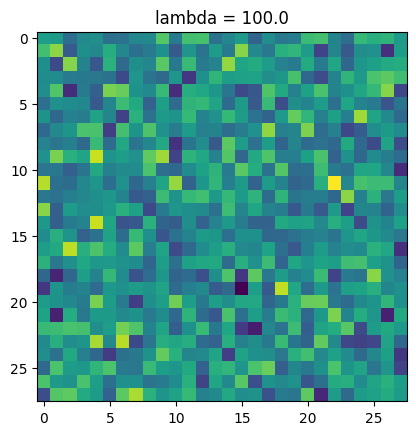

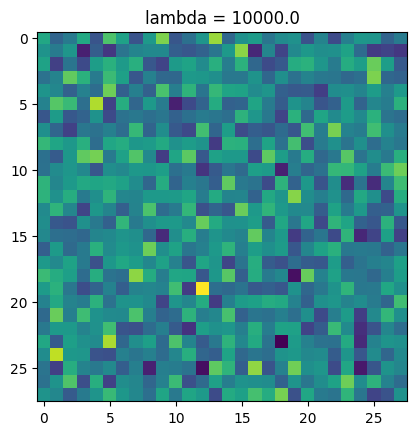

In [9]:

dm2.Q1_B(regularizer="L2")
dm2.Q1_C(train_data, train_labels, regularizer="L2", rang=(0, 2))
dm2.Q1_D([1e-2, 5e1, 1e2, 1e4], regularizer="L2")

$\newcommand{\pr}{\mathbb{P}}$

## Linear Discriminant Analysis ##

We now consider a model called LDA that models the data as a Gaussian Distribution : $\mathcal{N}(\mu_1, \Sigma)$ and $\mathcal{N}(\mu_{-1}, \Sigma)$.

Let $\pi = \mathbb{P}(Y = 1)$.

En utilisant la formule de Bayes et avec $\pi=\pr(Y=1)$ :
$$\begin{align*}
\pr(Y=1|X) &= \frac{\pr(X|Y=1)\pi}{\pr(X)}\\
&= \frac{\pr(X|Y=1)\pi}{\pr(X|Y=1)\pi + \pr(X|Y=-1)(1-\pi)}\\
&= \frac 1 {1+\frac{\pr(X|Y=-1)}{\pr(X|Y=1)}\frac{1-\pi}{\pi}}\\
\end{align*}$$
Or on a :
$$\begin{align*}
\log\bigg(\frac{\pr(X|Y=1)}{\pr(X|Y=-1)}\bigg) &= \frac 1 2 \big((X-\mu_1)^T\Sigma^{-1}(X-\mu_1) - (X-\mu_{-1})^T\Sigma^{-1}(X-\mu_{-1}) \big)\\
&= \frac 1 2 \big( X^T\Sigma^{-1}(\mu_{-1}-\mu_{1}) - \mu_1^T\Sigma^{-1}(X-\mu_1) + \mu_{-1}^T\Sigma^{-1}(X-\mu_{-1})\big)\\
&= \frac 1 2 \big(X^T\Sigma^{-1}(\mu_{-1} - \mu_1) + (\mu_{-1} - \mu_1)^T\Sigma^{-1}X + \mu_1^T\Sigma^{-1}\mu_1 - \mu_{-1}^T\Sigma^{-1}\mu_{-1}\big)\\
\end{align*}$$

On utilise le fait que $X^T\Sigma^{-1}(\mu_{-1} - \mu_1)$ est égal à sa transposé (car c'est un scalaire):
$$\begin{align*}
    &= \frac 1 2 \big(-\langle\alpha_1, X \rangle - \alpha_0\big)
\end{align*}$$
Avec:
$$\begin{align*}
    \alpha_1 &= (\Sigma^{-1} + {\Sigma^{-1}}^T)(\mu_{1} - \mu_{-1})\\
    \alpha_0 &= \mu_1^T\Sigma^{-1}\mu_1 - \mu_{-1}^T\Sigma^{-1}\mu_{-1}\\
\end{align*}$$
On obtient finalement :
$$\begin{align*}
\pr(Y=1|X) &= \frac{\pr(X|Y=1)\pi}{\pr(X)}\\
&= \frac 1 {1 + \exp\big(-\beta_0 - \langle\beta_1, X\rangle \big)}\\
\end{align*}$$
Avec :
$$\begin{align*}
\beta_0 &= \log\big(\frac\pi{1-\pi}\big) + \alpha_0/2 \\
\beta_1 &= \alpha_1/2
\end{align*}$$

In [10]:
# This is just another implementation of SGD so to make it easier to read we will not develop it as we did for question 1. We will juste use already existing functions from pytorch.

class LDA_model():
    def __init__(self):
        self.pi = torch.randn(1).to(device) * 0.5 + 0.5
        self.mu1 = torch.randn(28 * 28).to(device)
        self.mu_1 = torch.randn(28 * 28).to(device)
        self.sigma_inv = torch.randn(28 * 28, 28 * 28).to(device)
    
    def forward(self, x, y = None):
        #compute the probability for y = 1 | x
        #x : (batch_size, 28 * 28)

        beta_0 = torch.log(self.pi / (1 - self.pi))\
                + 0.5 * (self.mu1.T @ self.sigma_inv @ self.mu1
                - self.mu_1 @ self.sigma_inv @ self.mu_1)
        
        beta = 0.5 * (self.sigma_inv + self.sigma_inv.t()) @ (self.mu1 - self.mu_1)

        prod_scal = einsum("b i, i -> b", x, beta)

        self.z = beta_0 + prod_scal

        self.output = torch.sigmoid(self.z)
        if y is not None:
            self.loss = logist_loss(2 * self.output - 1, y) # this is to make the prediction in {-1, 1} instead of {0, 1}
        else:
            self.loss = None

        return self.output
    
    def backward(self, x, y, lr = 1e-3):
        z_grad = y + (torch.sigmoid(-self.z) - torch.sigmoid(self.z)) / 2

        dpi = (z_grad * (1-2*self.pi) / (self.pi * (1-self.pi))).mean()

        dmu1 = (z_grad * ((self.sigma_inv + self.sigma_inv.t()) @ (self.mu1 + x).T/2)).mean(dim = 1)
        dmu_1 = -(z_grad * ((self.sigma_inv + self.sigma_inv.t()) @ (self.mu_1 + x).T/2)).mean(dim = 1)

        mumux = einsum("b i, j -> b i j", x.to(torch.float16), self.mu1.to(torch.float16) - self.mu_1.to(torch.float16))

        dsigma = (z_grad.to(torch.float16)[:, None, None] * (torch.outer((self.mu1 - self.mu_1), (self.mu1 - self.mu_1))\
                               + mumux + torch.transpose(mumux, 1, 2))/2).mean(dim = 0)
    
        self.pi += lr * dpi
        self.mu1 += lr * dmu1
        self.mu_1 += lr * dmu_1
        self.sigma_inv += lr * dsigma
    
    def accuracy(self, y):
        return ((2 * self.output - 1) * y > 0).float().mean().item()

    def train(self, train_data, train_labels, test_data, test_labels, lr = 1e-4, n_epochs = 100, batch_size = 900):
        train_loss_list = []
        test_loss_list = []
        train_acc_list = []
        test_acc_list = []

        for epoch in tqdm(range(n_epochs)):
            #shuffle the data
            perm = torch.randperm(train_data.shape[0])
            train_data = train_data[perm]
            train_labels = train_labels[perm]

            #train
            for i in range(0, train_data.shape[0], batch_size):
                x = train_data[i : i + batch_size]
                y = train_labels[i : i + batch_size]

                self.forward(x, y)
                loss = self.loss.mean().item()
                self.backward(x, y, lr = lr)

                train_loss_list.append(loss)
                train_acc_list.append(self.accuracy(train_labels))
            
            #compute the loss and accuracy on the test set
            self.forward(test_data, test_labels)
            test_loss_list.append(self.loss.mean().item())
            test_acc_list.append(self.accuracy(test_labels))

        return train_loss_list, train_acc_list, test_loss_list, test_acc_list



In [16]:
# This is the exact same thing as the previous cell, but we use pytorch just to make it easier to read.
# Please note that the above cell consumes a fuck load of memory (for lack of better word) and you are highly advised to run this cell instead.
# Even after converting mumux to float16 sometimes my GPU is not happy.


from torch import nn

class LDA_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.mu1 = nn.Parameter(torch.randn(28 * 28).to(device))
        self.mu_1 = nn.Parameter(torch.randn(28 * 28).to(device))
        self.sigma = nn.Parameter(torch.randn(28 * 28, 28 * 28).to(device))
        self.pi = nn.Parameter(torch.rand(1).to(device))
    
    def forward(self, x, y = None):
        #compute the probability for y = 1 | x
        #x : (batch_size, 28 * 28)
        lambda_0 = 0.01
        sigma = self.sigma + lambda_0 * torch.eye(28 * 28).to(device)
        self.sigma_inv = torch.inverse(sigma)
        beta_0 = torch.log(self.pi / (1 - self.pi)) + 0.5 * (torch.matmul(torch.matmul(self.mu1, self.sigma_inv), self.mu1) - torch.matmul(torch.matmul(self.mu_1, self.sigma_inv), self.mu_1))
        beta = 0.5 * torch.matmul( (self.sigma_inv + self.sigma_inv.t()) , (self.mu1 - self.mu_1) )

        prod_scal = einsum("b i, i -> b", x, beta)

        self.output = torch.sigmoid(beta_0 + prod_scal)
        
        if y is not None:
            self.loss = logist_loss(2 * self.output - 1, y) # this is to make the prediction in {-1, 1} instead of {0, 1}
        else:
            self.loss = None

        return self.output
    
    def accuracy(self, y):
        return ((2 * self.output - 1) * y > 0).float().mean().item()

    def train(self, train_data, train_labels, test_data, test_labels, lr = 1e-3, n_epochs = 100, batch_size = 900):
        train_loss_list = []
        test_loss_list = []
        train_acc_list = []
        test_acc_list = []

        opt = torch.optim.SGD(self.parameters(), lr = lr)

        for epoch in range(n_epochs):
            #shuffle the data
            perm = torch.randperm(train_data.shape[0])
            train_data = train_data[perm]
            train_labels = train_labels[perm]

            #train
            for i in range(0, train_data.shape[0], batch_size):
                x = train_data[i : i + batch_size]
                y = train_labels[i : i + batch_size]

                opt.zero_grad()
                self.forward(x, y)
                loss = self.loss.mean().item()
                self.loss.mean().backward()
                opt.step()

                train_loss_list.append(loss)
                train_acc_list.append(self.accuracy(train_labels))
            
            #compute the loss and accuracy on the test set
            self.forward(test_data, test_labels)
            test_loss_list.append(self.loss.mean().item())
            test_acc_list.append(self.accuracy(test_labels))

        return train_loss_list, train_acc_list, test_loss_list, test_acc_list


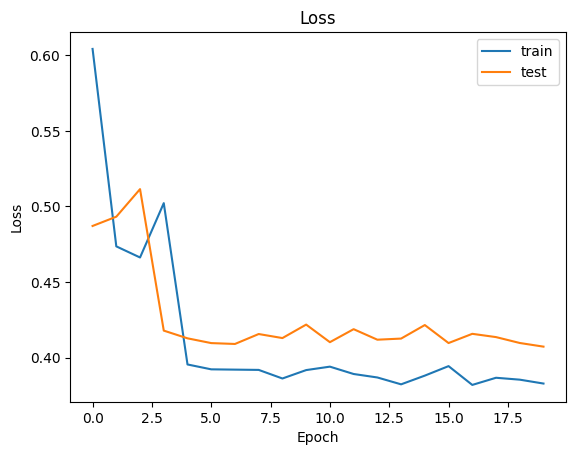

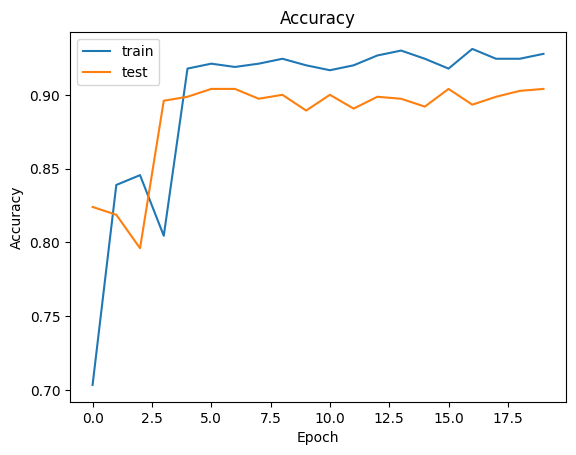

Final accuracy on the test set :  0.9039999842643738


In [17]:
# / ! \ Sometimes the model stucks in a local minimum where the accuracy is 0.67. If it happens, just rerun the cell.

def Q2_C(train_data, train_labels, test_data, test_labels):
    model = LDA_model()
    train_loss_list, train_acc_list, test_loss_list, test_acc_list = model.train(train_data, train_labels, test_data, test_labels, lr = 1e-2, n_epochs = 20, batch_size = 900)

    plt.figure()
    plt.plot(train_loss_list, label = "train")
    plt.plot(test_loss_list, label = "test")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_acc_list, label = "train")
    plt.plot(test_acc_list, label = "test")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    print("Final accuracy on the test set : ", test_acc_list[-1])

    return model

train_reshaped = train_data.reshape((900, 28 * 28))
test_reshaped = test_data.reshape((750, 28 * 28))
model = Q2_C(train_reshaped, train_labels, test_reshaped, test_labels)

Confusion matrix for the training set : 
[[0.89       0.11      ]
 [0.07166667 0.92833333]]


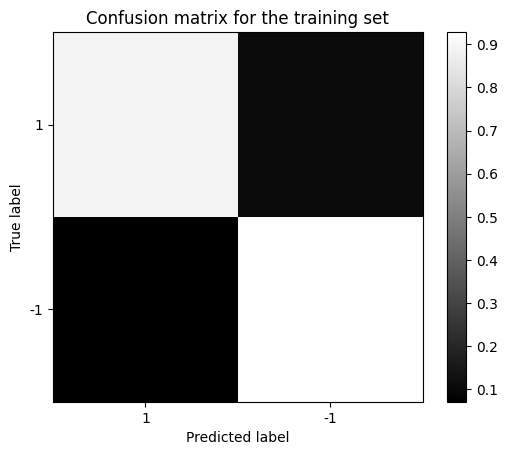

In [79]:
# Plot the confusion matrix for the training set :

confusion_matrix = np.zeros((2, 2))

model.forward(train_reshaped)
pred = (2 * model.output - 1)

confusion_matrix[0, 0] = ((pred > 0) * (train_labels == 1)).float().mean().item()
confusion_matrix[0, 1] = ((pred < 0) * (train_labels == 1)).float().mean().item()
confusion_matrix[1, 0] = ((pred > 0) * (train_labels == -1)).float().mean().item()
confusion_matrix[1, 1] = ((pred < 0) * (train_labels == -1)).float().mean().item()

confusion_matrix[0] /= confusion_matrix[0].sum()
confusion_matrix[1] /= confusion_matrix[1].sum()

print("Confusion matrix for the training set : ")
print(confusion_matrix)

plt.figure()
plt.imshow(confusion_matrix, cmap = "gray")
plt.title("Confusion matrix for the training set")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["1", "-1"])
plt.yticks([0, 1], ["1", "-1"])
plt.colorbar()
plt.show()

C:\Users\gdhim\AppData\Local\Temp\ipykernel_4896\988717975.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  sample1 = np.random.multivariate_normal(mu1, model.sigma.detach().cpu().numpy(), 1)
C:\Users\gdhim\AppData\Local\Temp\ipykernel_4896\988717975.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  sample_1 = np.random.multivariate_normal(mu_1, model.sigma.detach().cpu().numpy(), 1)


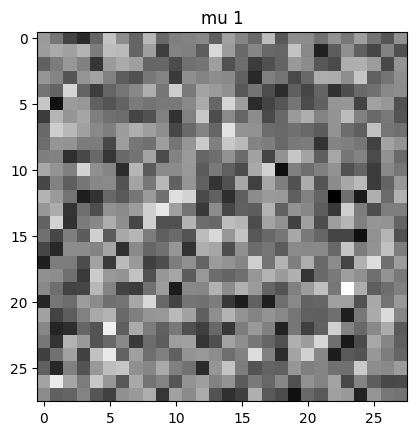

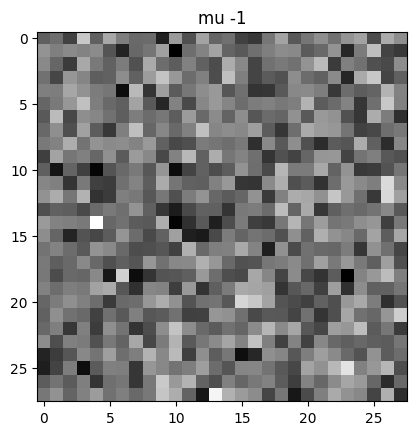

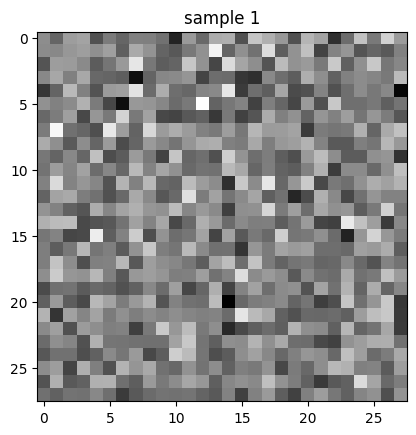

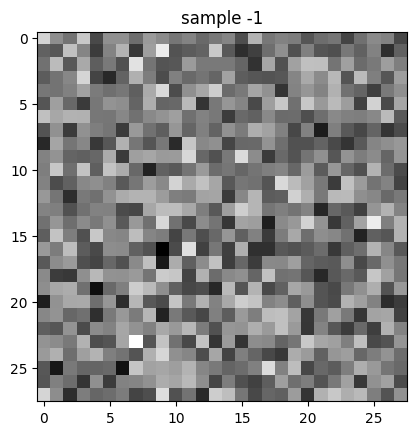

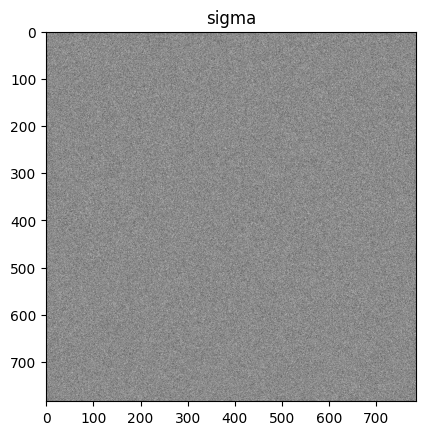

In [70]:
#plot a random samble from the mu1 and mu_1 distributions, and the exact means :

mu1 = model.mu1.detach().cpu().numpy()
mu_1 = model.mu_1.detach().cpu().numpy()

sample1 = np.random.multivariate_normal(mu1, model.sigma.detach().cpu().numpy(), 1)
sample_1 = np.random.multivariate_normal(mu_1, model.sigma.detach().cpu().numpy(), 1)

plt.figure()
plt.imshow(mu1.reshape((28, 28)), cmap = "gray")
plt.title("mu 1")
plt.show()

plt.figure()
plt.imshow(mu_1.reshape((28, 28)), cmap = "gray")
plt.title("mu -1")
plt.show()

plt.figure()
plt.imshow(sample1.reshape((28, 28)), cmap = "gray")
plt.title("sample 1")
plt.show()

plt.figure()
plt.imshow(sample_1.reshape((28, 28)), cmap = "gray")
plt.title("sample -1")
plt.show()

plt.figure()
plt.imshow(model.sigma.detach().cpu().numpy(), cmap = "gray")
plt.title("sigma")
plt.show()

## Unsupervised Learning ##

We will now implement the K-means $++$ algorithm, and then a PCA to visualise the separation of the data. Then we will associate to each cluster a letter the see the confusion matrix.

In [18]:
def kmeans(k, train_data, train_labels, test_data, test_labels):
    #reshape the images into vectors
    train_data = train_data.reshape((900, 28 * 28))
    test_data = test_data.reshape((750, 28 * 28))

    #initialize the k points
    k0 = torch.randint(0, 900, (1,)).item()
    k0 = train_data[k0]

    k_stack = torch.zeros((k, 28 * 28)).to(device)
    k_stack[0] = k0

    for i in range(k - 1):
        distances = torch.cdist(train_data, k_stack[:i + 1])
        
        #first, find the minimum distance between each point and the k points we already have
        #this gives the distance from each point to the closest point among the k points we already have
        #then, find the maximum of these minimums
        #this is the furthest point from the k points we already have

        min_distances = torch.min(distances, dim = 1)[0]
        #we take the [0] because the function returns a tuple with the values and the indices, we only want the values
        max_index = torch.argmax(min_distances)

        k_stack[i + 1] = train_data[max_index]

    #now we have initialized the k points, we can start the clustering process

    #until the representative points do not change anymore
    while True:
        #find the closest representative point for each data point
        distances = torch.cdist(train_data, k_stack)
        closest = torch.argmin(distances, dim = 1)

        #find the new representative points
        new_k_stack = torch.zeros((k, 28 * 28)).to(device)
        for i in range(k):
            #find the center of mass of the cluster
            new_k_stack[i] = torch.mean(train_data[closest == i], dim = 0)

        #check if the representative points have changed
        if torch.all(torch.eq(new_k_stack, k_stack)):
            break
        else:
            k_stack = new_k_stack

    #As the k clusters are not points of the data, we cannot use the labels of the data to test the model.
    #Instead, we will use the labels of the representative points.
    #We will then check if the closest representative point has the same label as the test point.
    #If it does, we will say that the test point is correctly classified.

    #find the labels of the representative points
    #to do so, we say that the label of a representative point is the label of the closest data point to it
    #thus the distance is computed between the representative point and the data points as the transpose of the distance between the data points and the representative points
    distances = torch.cdist(k_stack, train_data)
    closest = torch.argmin(distances, dim = 1)
    # TODO : test with the ponderated mean of the labels of the closest data points
    k_labels = train_labels[closest]

    #now we can test the model
    #find the closest representative point for each test point
    distances = torch.cdist(test_data, k_stack)
    closest = torch.argmin(distances, dim = 1)

    #check if the closest representative point has the same label as the test point
    correct = torch.eq(k_labels[closest], test_labels)

    #return the percentage of correctly classified test points
    test_accuracy = torch.sum(correct).item() / 750

    #repeat for the training data
    distances = torch.cdist(train_data, k_stack)
    closest = torch.argmin(distances, dim = 1)

    #keep the distance only for the closest :
    closest_distance = distances[torch.arange(900), closest]
    sqr_dist_sum = torch.sum(torch.square(closest_distance))

    correct = torch.eq(k_labels[closest], train_labels)

    train_accuracy = torch.sum(correct).item() / 900

    return k_stack, k_labels, train_accuracy, test_accuracy, sqr_dist_sum

def kmeans10(k, train_data, train_labels, test_data, test_labels):
    run = []
    for i in range(10):
        k_stack, k_labels, train_accuracy, test_accuracy, sqr_dist_sum = kmeans(k, train_data, train_labels, test_data, test_labels)
        run.append((k_stack, k_labels, train_accuracy, test_accuracy, sqr_dist_sum))
    
    # find the best k_stack by finding the one with the lowest squared distance to the data points
    best = min(run, key = lambda x : x[4])

    return best


100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

training errors : tensor([0.6667, 0.6667, 0.3922, 0.4378, 0.1933, 0.1300, 0.1100, 0.1044, 0.1089,
        0.0956])
test errors : tensor([0.6667, 0.6667, 0.3987, 0.4280, 0.1827, 0.1293, 0.1120, 0.1120, 0.1093,
        0.1013])


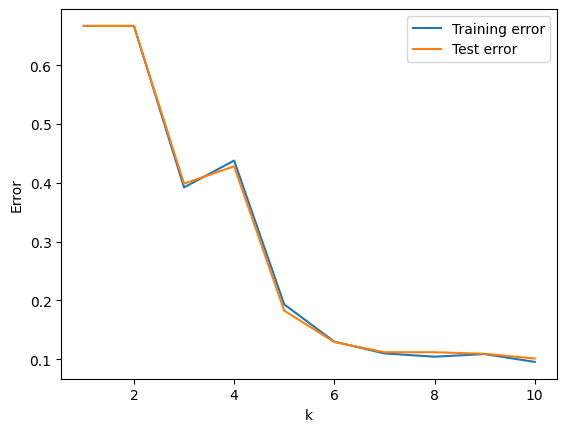

In [21]:
#plot the training and test errors as a function of k
k_values = torch.arange(1, 11)

k_stack_list = []
k_labels_list = []

train_errors = torch.zeros(10)
test_errors = torch.zeros(10)
for i in tqdm(range(10)):
    k_stack, k_labels, train_accuracy, test_accuracy, _ = kmeans10(k_values[i], train_data, train_labels, test_data, test_labels)

    k_stack_list.append(k_stack)
    k_labels_list.append(k_labels)

    train_errors[i] = 1 - train_accuracy
    test_errors[i] = 1 - test_accuracy

#print the training and test errors
print('training errors :', train_errors)
print('test errors :', test_errors)

plt.plot(k_values, train_errors, label = 'Training error')
plt.plot(k_values, test_errors, label = 'Test error')
plt.xlabel('k')
plt.ylabel('Error')
plt.legend()
plt.show()

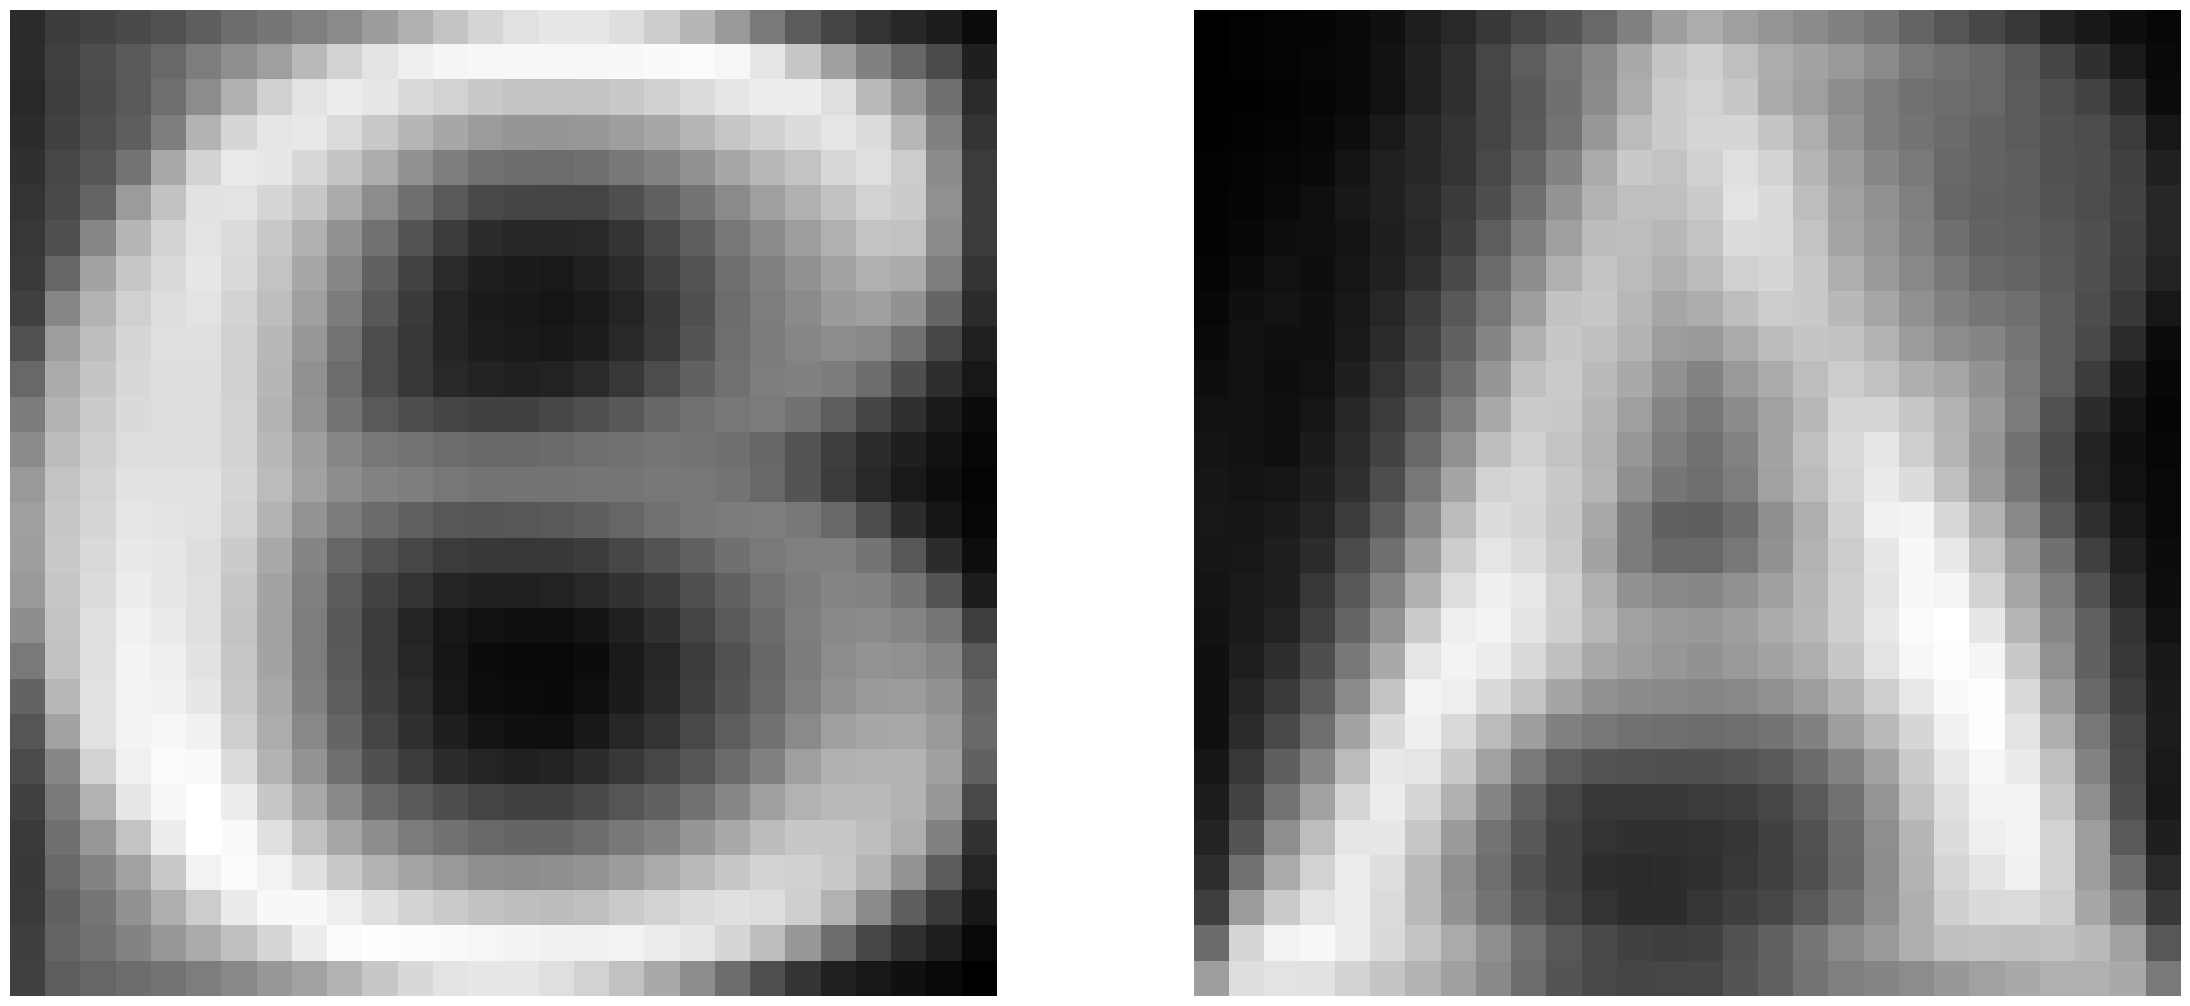

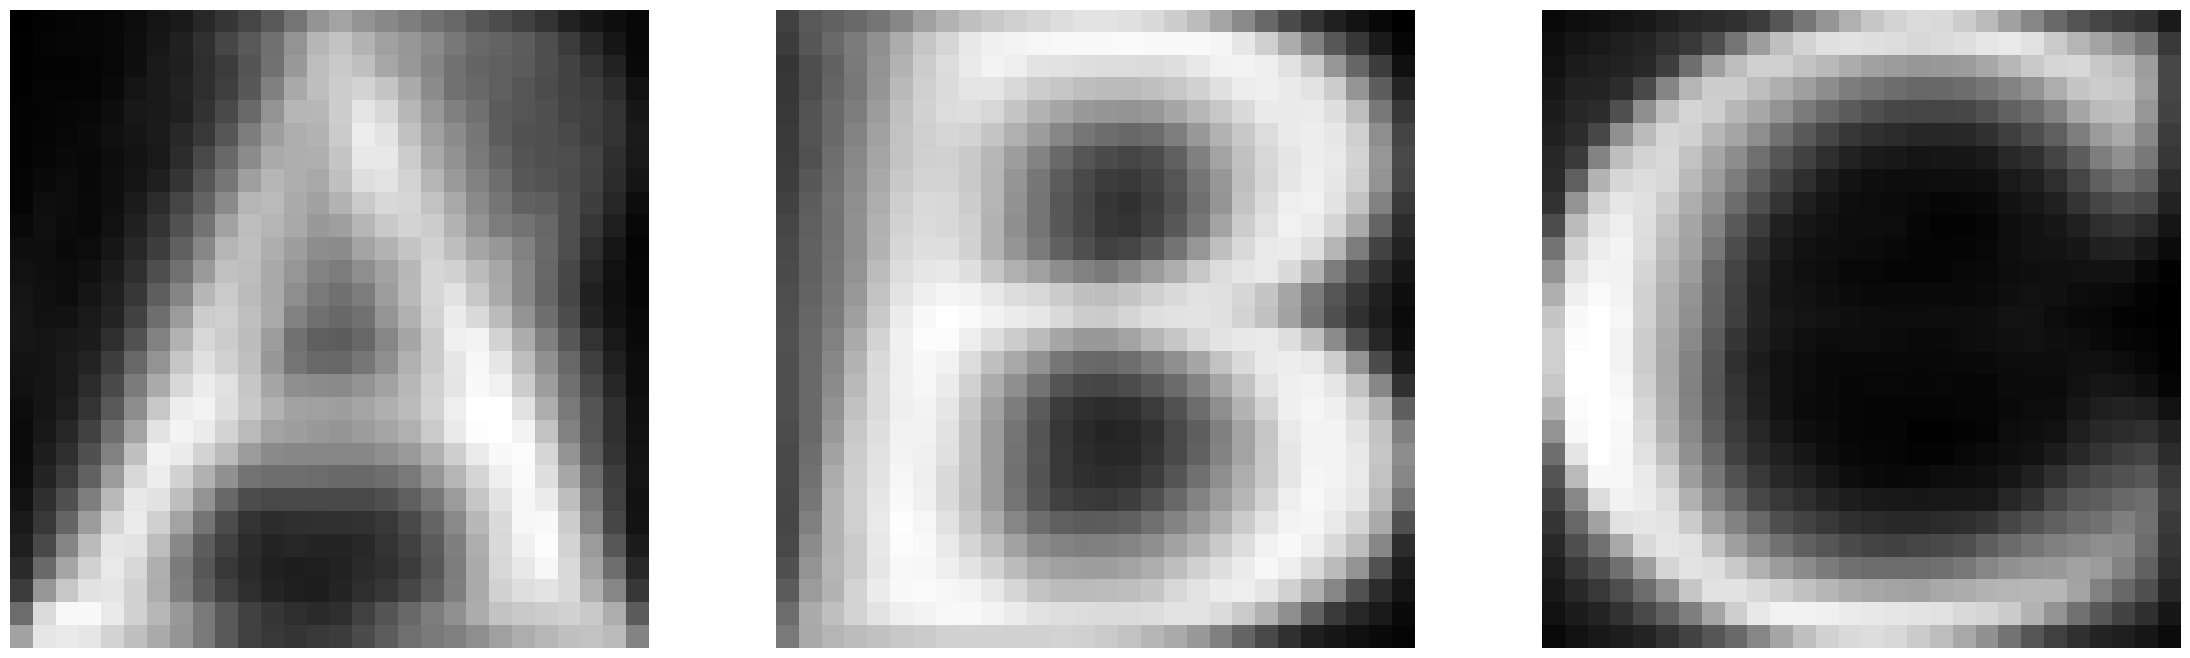

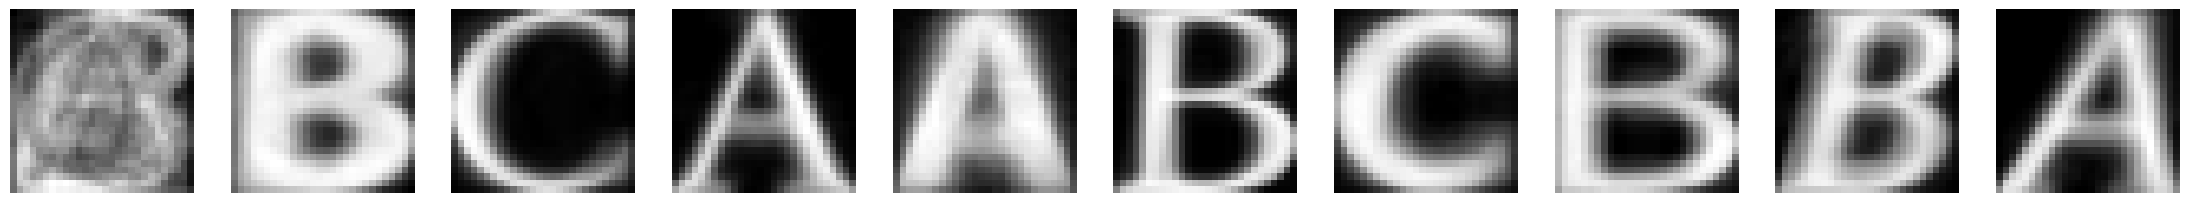

In [22]:
def plot_k(k):
    #reshape the images into 28 * 28 matrices
    k_stack = k_stack_list[k - 1].reshape((k, 28, 28))

    #plot the images
    fig, ax = plt.subplots(1, k, figsize = (28, 28))
    for i in range(k):
        ax[i].imshow(k_stack[i].cpu().numpy(), cmap = 'gray')
        ax[i].axis('off')
    plt.show()

plot_k(2)
plot_k(3)
plot_k(10)

To make a PCA we have to find the eigen vector associated to the highest eigen value.

In [23]:
X = train_data.reshape((900, 28 * 28))
X = X.T @ X

#compute the eigenvalues and eigenvectors of X and keep only the real part
eigenvalues, eigenvectors = torch.linalg.eigh(X)
eigenvalues = eigenvalues.real
eigenvectors = eigenvectors.real

In [24]:
#sort the eigenvalues and eigenvectors by decreasing eigenvalue
perm = torch.argsort(eigenvalues, descending = True)
eigenvalues = eigenvalues[perm]
eigenvectors = eigenvectors[:, perm]

In [25]:
w0 = eigenvectors[:, 0].reshape((28*28, 1))
# Please note that if the first two eigenvalues are not equal, we can directly pick w1 here as w0 and w1 are orthogonal.
# However, I decided to keep the implementation given in class by projecting the data onto the orthogonal complement of w0.
# w1 = eigenvectors[:, 1].reshape((28*28, 1))

#project the data onto the orthogonal complement of w.
#To do so, project the data onto w and subtract the result from the data. As w is a unit vector, the projection of the data onto w is simply the dot product of w and the data times w.
X = train_data.reshape((900, 28 * 28))

xonw = (X @ w0) @ w0.T

X = X - xonw

In [26]:
X = X.T @ X

eigenvalues, eigenvectors = torch.linalg.eigh(X)
eigenvalues = eigenvalues.real
eigenvectors = eigenvectors.real

perm = torch.argsort(eigenvalues, descending = True)
eigenvalues = eigenvalues[perm]
eigenvectors = eigenvectors[:, perm]

w1 = eigenvectors[:, 0].reshape((28*28, 1))

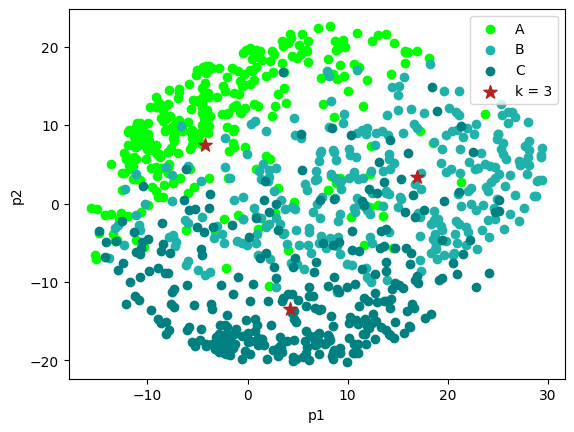

In [27]:
#Now, project the data onto w0 and w1 and plot the result.

reshaped_data = train_data.reshape((900, 28 * 28))
p1 = (reshaped_data @ w0).to('cpu').numpy()
p2 = (reshaped_data @ w1).to('cpu').numpy()

A = (p1[:300], p2[:300])
B = (p1[300:600], p2[300:600])
C = (p1[600:], p2[600:])

plt.scatter(*A, label = 'A', c = 'lime')
plt.scatter(*B, label = 'B', c = 'lightseagreen')
plt.scatter(*C, label = 'C', c = 'teal')

#plot as colored stars the representative points of the k-means algorithm for k = 2, 3 and 10
color = [None, 'darkred', 'firebrick', None, None, None, None, None, None, 'indianred']
for k in [3]:#[2, 3, 10]:
    k_stack = k_stack_list[k - 1]
    p1k = (k_stack @ w0).to('cpu').numpy()
    p2k = (k_stack @ w1).to('cpu').numpy()
    plt.scatter(p1k, p2k, marker = '*', label = 'k = ' + str(k), c = color[k - 1], s = 100)

plt.xlabel('p1')
plt.ylabel('p2')
plt.legend()
plt.show()

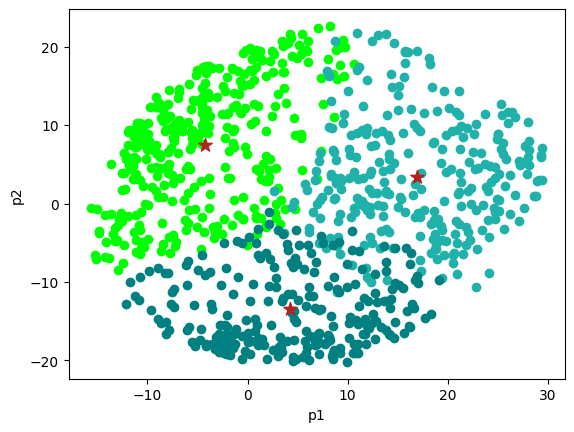

In [28]:
# Same but coloring based on the cluster :
# first compute the closest representative point for each data point
X = train_data.reshape((900, 28 * 28))

clusters = k_stack_list[3 - 1]
distances = torch.cdist(X, clusters)
closest = torch.argmin(distances, dim = 1).to('cpu').numpy()

plt.scatter(p1[closest == 0], p2[closest == 0], c = 'lime')
plt.scatter(p1[closest == 1], p2[closest == 1], c = 'lightseagreen')
plt.scatter(p1[closest == 2], p2[closest == 2], c = 'teal')

p1k = (clusters @ w0).to('cpu').numpy()
p2k = (clusters @ w1).to('cpu').numpy()
plt.scatter(p1k, p2k, marker = '*', label = 'k = ' + str(k), c = color[k - 1], s = 100)

plt.xlabel('p1')
plt.ylabel('p2')
plt.show()

C:\Users\gdhim\AppData\Local\Temp\ipykernel_3856\2114839722.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closest = torch.tensor(closest)


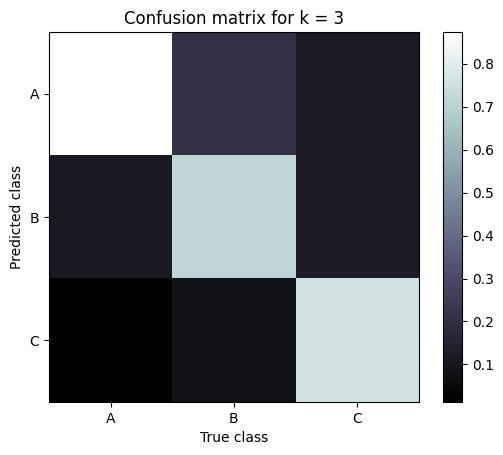

In [35]:
# Now compute the confusion matrix for k = 3 :

confusion_matrix = torch.zeros((3, 3))
closest = torch.tensor(closest)

for i in range(3):
    for j in range(3):
        confusion_matrix[i, j] = torch.mean((closest[j * 300 : (j+1) * 300] == i).float())

# / ! \ Due to non ordonated clusters, the confusion matrix is not always the same and some times it is non diagonal.
plt.imshow(confusion_matrix, cmap = 'bone')
plt.xlabel('True class')
plt.ylabel('Predicted class')
plt.title('Confusion matrix for k = 3')
plt.xticks([0, 1, 2], ['A', 'B', 'C'])
plt.yticks([0, 1, 2], ['A', 'B', 'C'])
plt.colorbar()
plt.show()

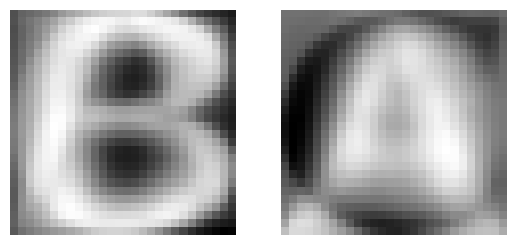

In [31]:
# BONUS : plotting the PCA as images.

w0 = w0.reshape((28, 28)).to('cpu').numpy()
w1 = w1.reshape((28, 28)).to('cpu').numpy()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(w0, cmap = 'gray')
ax[0].axis('off')
ax[1].imshow(w1, cmap = 'gray')
ax[1].axis('off')
plt.show()